<a href="https://colab.research.google.com/github/Tyluuus/MemotionAnalysis/blob/udpates/GSN_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GSN21Z Projekt 

Celem projektu będzie realizacja tasku B znajdującego się pod challengem Memotion na platformie Kaggle: https://www.kaggle.com/williamscott701/memotion-dataset-7k


Treść zadania: *Task B- Humor Classification: Given an Internet meme, the system has to identify the type of humor expressed. The categories are sarcastic, humorous, and offensive meme. If a meme does not fall under any of these categories, then it is marked as another meme. A meme can have more than one category.*





Dataset: W datasecie znajduje się 6992 memów pobranych z platformy reddit oraz oznaczonych z wykorzystaniem usługi Amazon Mechanical Turk. Oznaczenia znajdują się w pliku csv, który zawiera: 
1.   Nazwę pliku z memem
2.   Tekst uzyskany z wykorzystaniem OCR
3.   Tekst poprawiony
4.   Klasa humorystyczna
5.   Klasa sarkastyczna
6.   Klasa ofensywna
7.   Klasa motywacyjna


## Gałąź przetwarzania obrazów

In [122]:
# Use trained model variable
use_trained_model = True
save_model = True
image_save_model_path = './drive/MyDrive/GSN_dataset/memotion_images_model_1_epoch.pt'
text_save_model_path = './drive/MyDrive/GSN_dataset/memotion_text_model_1_epoch.pt'
image_load_model_path = './MemotionAnalysis/memotion_images_model_1_epoch.pt'
text_load_model_path = './MemotionAnalysis/memotion_text_model_1_epoch.pt'

In [156]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [123]:
text_epochs = 1 # 250
image_epochs = 1 # 20
text_batch_size = 4
image_batch_size = 16

same_batch_size = 4

In [124]:
#sklonowanie repozytorium z githuba - pobranie plików składających się na dataset - zdjęć oraz pliku csv
#pobierane są również pliki niezbędne do wczytania modelu sieci
!git clone https://github.com/Tyluuus/MemotionAnalysis.git

fatal: destination path 'MemotionAnalysis' already exists and is not an empty directory.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
#Imports

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import cv2
import time
import copy
import os
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets, models
from PIL import Image
from google.colab.patches import cv2_imshow
from torchtext.legacy.data import Dataset, Example, Field
from torchtext.legacy.data import BucketIterator

In [127]:
# Dictionaries for mapping word classification
class_humour_weights = {"hilarious": 3, "not_funny": 0, "very_funny": 2, "funny": 1}
class_sarcasm_weights = {"general": 1, "not_sarcastic": 0, "twisted_meaning": 2, "very_twisted": 3}
class_offensive_weights = {"not_offensive": 0, "slight": 1, "very_offensive": 2, "hateful_offensive": 3}
class_motivational_weights = {"not_motivational": 0, "motivational": 1}

# Directory containing images
images_dir = "./MemotionAnalysis/images/"

In [128]:
# Loading custom dataset into PyTorch class
class MyCustomDataset(Dataset):
    def __init__(self, csv_path, low_data_mode=False, debug=False):
        """
        Args:
          csv_path (string): path to csv file  
          debug (boolean): debug mode toogle
        """
        # If system is in debug mode
        self.debug = debug


        # Read the csv_file
        if low_data_mode==True:
          self.data_info = pd.read_csv(csv_path, header = 6952)
        else:
          self.data_info = pd.read_csv(csv_path, header = 3)

        # Column containing image names
        self.image_arr = np.asarray(self.data_info.iloc[:, 1])

        # Columns containing emotions classification
        self.humour_arr = np.asarray(self.data_info.iloc[:, 4])
        self.sarcasm_arr = np.asarray(self.data_info.iloc[:, 5])
        self.offensive_arr = np.asarray(self.data_info.iloc[:, 6])
        self.motivational_arr = np.asarray(self.data_info.iloc[:, 7])
        


        # Transforms performed on loaded image
        self.data_transforms = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        # Array with class vectors for each image
        self.labels = []

        # Mapping word classification to 4 numeric classes
        for index in range(len(self.humour_arr)):
          humour_value = class_humour_weights[self.humour_arr[index]]
          sarcasm_value = class_sarcasm_weights[self.sarcasm_arr[index]]
          offensive_value = class_offensive_weights[self.offensive_arr[index]]
          motivational_value = class_motivational_weights[self.motivational_arr[index]]

          if humour_value > sarcasm_value:
            if humour_value > offensive_value:
              if humour_value > motivational_value:
                var = 0
              else:
                var = 3 
            else:
              if offensive_value > motivational_value:
                var = 2
              else: 
                var = 3
          else:
            if sarcasm_value > offensive_value:
              if sarcasm_value > motivational_value:
                var = 1
              else:
                var = 3
            else: 
              if offensive_value > motivational_value: 
                var = 2
              else:
                var = 3

          # Creating class vector
          lab = [0.0, 0.0, 0.0, 0.0]
          lab[var] = 1.0
          
          # Adding new image class vector to labels array
          self.labels.append(lab) 

        # Calculate of dataset
        self.data_len = len(self.data_info.index)
        
        # Set correct path to images
        self.image_arr = images_dir + self.image_arr

        
    def __getitem__(self, index):
        """
        Args:
          index (int): index of item to get  

        Returns:
          Tuple of image and class vector as tensors
        """
        img_as_img = None
        single_image_name = None


        try:
          # Get image name from pandas df
          single_image_name = self.image_arr[index]

          # # Open image with PIL and convert to RGB image
          img = Image.open(single_image_name).convert('RGB')
          if self.debug==True:
            print('1:', img)

          # Transform image and convert to tensor
          img_as_tensor = self.data_transforms(img)

          if self.debug==True:
            print('2:', img_as_tensor)

          # Get class vector of the image from labels array
          img_label = self.labels[index]

          if self.debug==True:
            print('3:',img_label)

          # Convert class vector to tensor
          img_label = torch.as_tensor(img_label)
          
          if self.debug==True:
            print('4:',img_label)

          return (img_as_tensor, img_label)

        except:
          print("Image loading error for:",single_image_name)
          return ('ERROR', torch.tensor([-1]))

    def __len__(self):
        return self.data_len

In [129]:
# Switch to using GPU

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [130]:
# Loading images into custom dataset
dataset = MyCustomDataset('MemotionAnalysis/labels.csv', low_data_mode=False)

# Loading dataset into DataLoader and setting batch_size
b_size = same_batch_size if use_trained_model else image_batch_size
dataloader = torch.utils.data.DataLoader(dataset, batch_size=b_size, shuffle=False, num_workers=1)
dataset_size = len(dataloader)

In [131]:
# Text preprocessing

meme_text = dataset.data_info.iloc[:, 3]

raw_df = []

for i in range(len(meme_text)):
    raw_df.append([str(meme_text[i]), dataset.labels[i]])

df = pd.DataFrame(raw_df[:-3], columns=['text', 'label'])

text_field = Field(
    sequential=True,
    tokenize='basic_english', 
    fix_length=50,
    lower=True
)
label_field = Field(sequential=False, use_vocab=False)
# prepocess
preprocessed_text = df['text'].apply(
    lambda x: text_field.preprocess(x)
)
# load fastext simple embedding with 100d
text_field.build_vocab(
    preprocessed_text, 
    vectors='glove.6B.100d'
)

In [132]:
class DataFrameDataset(Dataset):
    def __init__(self, df: pd.DataFrame, fields: list):
        super(DataFrameDataset, self).__init__(
            [
                Example.fromlist(list(r), fields) for i, r in df.iterrows()
            ], 
            fields
        )

train_dataset, test_dataset = DataFrameDataset(
    df=df, 
    fields=(
        ('text', text_field),
        ('label', label_field)
    )
).split(split_ratio=0.85)

b_size = same_batch_size if use_trained_model else text_batch_size

train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), 
    batch_sizes=(b_size, b_size),
    sort=False
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


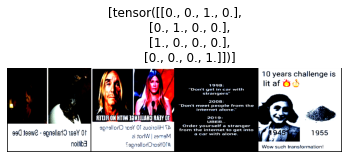

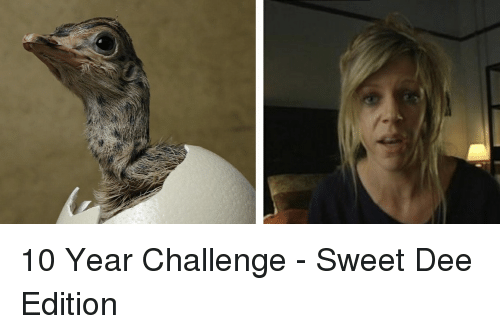

In [134]:
# Check loaded data

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[classes])

# Get a batch of training data
inputs, classes = next(iter(dataloader))
show_databatch(inputs, classes)
cv2_imshow(cv2.imread(dataset.image_arr[0]))
# print(dataset.text_arr[0])
# print(dataset.df['text'][0])
# print(dataset.train_dataset[0].text)
# print(next(iter(dataset.train_iter)).text)

In [158]:
# Downloading pretrained vgg16

! gdown --id 1f3iqJY2NDTsJP2_BFmtk5WtcfAW9nwdl

Downloading...
From: https://drive.google.com/uc?id=1f3iqJY2NDTsJP2_BFmtk5WtcfAW9nwdl
To: /content/vgg16_bn.pth
100% 554M/554M [00:05<00:00, 95.9MB/s]


In [199]:
# Load the pretrained model from PyTorch

vgg16 = models.vgg16_bn()
vgg16.load_state_dict(torch.load("/content/vgg16_bn.pth")) 

# Print to see network architecture
# print(vgg16)

<All keys matched successfully>

In [200]:
# if use_trained_model==False:

  # Class with own modification of VGG16 architecture - classifier was changed - 
  # after getting features from image there is pooling layer, next results are flattened and feed to fully connected layer with output number = 4
  # at the end sigmoid function is used

class custom_vgg16(nn.Module):
    def __init__(self, model):
        super(custom_vgg16, self).__init__()

        self.features = list(model.features)
        self.features = nn.Sequential(*self.features)
        self.pooling = model.avgpool
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=25088, out_features=4, bias=True)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        out = self.features(x)
        out = self.pooling(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.sigm(out)
        return out


In [201]:
# if use_trained_model==False:

class ModelParam(object):
    def __init__(self, param_dict: dict = dict()):
        self.input_size = param_dict.get('input_size', 0)
        self.vocab_size = param_dict.get('vocab_size')
        self.embedding_dim = param_dict.get('embedding_dim', 100)
        self.target_dim = param_dict.get('target_dim')
        
class TextModel(nn.Module):
    def __init__(self, model_param: ModelParam):
        super().__init__()
        self.embedding = nn.Embedding(model_param.vocab_size, model_param.embedding_dim)
        self.conv = nn.Conv1d(50, 4, 1)
        self.max_pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(50,16)
        self.fc = nn.Linear(in_features=16, out_features=1, bias=True)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        features = self.embedding(x)
        features = F.relu(features)
        features = self.conv(features)
        features = self.max_pool(features)
        features, hidden = self.lstm(features)
        features = self.fc(features)
        features = self.sigm(features)
        return features

In [202]:
# Loading custiom VGG16 from loaded, pretrained VGG16 model
vgg16 = custom_vgg16(vgg16)

# if use_trained_model==True:
#   vgg16.load_state_dict(torch.load('/content/drive/MyDrive/GSN_dataset/memotion_images_model.pt'))

In [203]:
# Set VGG16 to run on GPU
if use_gpu:
    vgg16.cuda()
    
criterion = nn.BCELoss()

# Define optimizer and LR Scheduler for training
optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.0003)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [204]:
# F1 score calculating for image
image_f1_data = {
    0: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    },
    1: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    },
    2: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    },
    3: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    }
}

def clear_image_f1_data():
    for i in range(4):
        image_f1_data[i]["true_positive"] = 0.0
        image_f1_data[i]["false_positive"] = 0.0
        image_f1_data[i]["false_negative"] = 0.0

def update_image_f1_data(preditions: list, labels: list):
    for i in range(len(preditions)):
        if(preditions[i] == labels[i]):
            image_f1_data[labels[i]]["true_positive"] += 1.0
        else:
            image_f1_data[labels[i]]["false_positive"] += 1.0
            image_f1_data[preditions[i]]["false_negative"] += 1.0
                

def calculate_image_f1_for_class(class_number: int):
    precision_divider = image_f1_data[class_number]["true_positive"]+image_f1_data[class_number]["false_positive"]
    precision = (image_f1_data[class_number]["true_positive"] / precision_divider) if precision_divider > 0 else 0
    recall_divider = image_f1_data[class_number]["true_positive"]+image_f1_data[class_number]["false_negative"]
    recall = (image_f1_data[class_number]["true_positive"] / recall_divider) if recall_divider > 0 else 0
    #print(f"Precision: {precision} , Recall: {recall} ")
    return (2 * (precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0

def calculate_image_macro_f1():
    macro_f1 = 0.0
    for i in range(4):
        macro_f1 += calculate_image_f1_for_class(i)
    return macro_f1/4

In [205]:
text_f1_data = {
    0: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    },
    1: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    },
    2: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    },
    3: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    }
}

def clear_text_f1_data():
    for i in range(4):
        text_f1_data[i]["true_positive"] = 0.0
        text_f1_data[i]["false_positive"] = 0.0
        text_f1_data[i]["false_negative"] = 0.0

def update_text_f1_data(preditions: list, labels: list):
    for i in range(len(preditions)):
        if(preditions[i] == labels[i]):
            text_f1_data[labels[i]]["true_positive"] += 1.0
        else:
            text_f1_data[labels[i]]["false_positive"] += 1.0
            text_f1_data[preditions[i]]["false_negative"] += 1.0
                

def calculate_text_f1_for_class(class_number: int):
    if text_f1_data[class_number]["true_positive"] == 0:
      return 0
    precision = text_f1_data[class_number]["true_positive"] / (text_f1_data[class_number]["true_positive"]+text_f1_data[class_number]["false_positive"])
    recall = text_f1_data[class_number]["true_positive"] / (text_f1_data[class_number]["true_positive"]+text_f1_data[class_number]["false_negative"])
    # print(f"Precision: {precision} , Recall: {recall} ")
    return 2 * (precision * recall) / (precision + recall)

def calculate_text_macro_f1():
    macro_f1 = 0.0
    for i in range(4):
        macro_f1 += calculate_text_f1_for_class(i)
    return macro_f1/4

In [206]:
def classes_convert(classes):
  clas = []
  for element in range(len(classes)):
    var = classes[element]
    for index in range(len(var)):
      if var[index]==1:
        clas.append(index)
  return torch.tensor(clas)

In [207]:
# Defining training model
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=1, debug=False):
    """
    Args:
      vgg (nn.Model): Neural Network model to traing
      criterion (nn.LossFunction): Loss Function 
      optimizer (torch.optim): Optimalization Function
      scheduler (torch.optim.lr_scheduler): Learning Rate Scheduler
      num_epochs (int): Number of training epochs
      debug (boolean): Debug mode toogle
    """

    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloader)
    val_batches = len(dataloader)
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        target_true = 0
        predicted_true = 0
        correct_true = 0
        
        vgg.train(True)
        clear_image_f1_data()
        for inputs, classes in iter(dataloader):
            if use_gpu:
                sample, clas = Variable(inputs.cuda()), Variable(classes.cuda())
            else:
                sample, clas = Variable(inputs), Variable(classes)
            
            # addressing batch labels to list
            batch_labels = []
            for row in clas.data:
              for i in range(len(row)):
                if row[i] == 1:
                  batch_labels.append(i)
            
            if use_gpu:
              batch_labels = torch.tensor(batch_labels).cuda()
            else:
              batch_labels = torch.tensor(batch_labels)
            
            optimizer.zero_grad()
            outputs = vgg(sample)

            if debug==True:
              print(outputs)
              print(clas)

            _, preds = torch.max(outputs.data, -1)
            loss = criterion(outputs, clas)
            
            loss.backward()
            optimizer.step()

            update_image_f1_data(preds.squeeze().tolist(), batch_labels.squeeze().tolist())
            
            del sample, clas, outputs, preds
            torch.cuda.empty_cache()
        
        epoch_train_macro_f1 = calculate_image_macro_f1()
        
        vgg.train(False)
        vgg.eval()
        clear_image_f1_data()    
        for inputs, classes in iter(dataloader):
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(classes.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(classes)

            # addressing batch labels to list
            batch_labels = []
            for row in labels.data:
              for i in range(len(row)):
                if row[i] == 1:
                  batch_labels.append(i)
            
            if use_gpu:
              batch_labels = torch.tensor(batch_labels).cuda()
            else:
              batch_labels = torch.tensor(batch_labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            # Prediction
            _, preds = torch.max(outputs.data, 1)
            if debug==True:
              print("Preds: ",preds)
            loss = criterion(outputs, labels)
            if debug==True:
              print("[1]Classes shape: ",classes.shape)
              print("[1]Classes: ",classes)

            classes = classes_convert(classes)
            if debug==True:
              print("[2]Classes: ",classes.shape)
              print("[2]Classes: ",classes)
            
            update_image_f1_data(preds.squeeze().tolist(), batch_labels.squeeze().tolist())
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        epoch_val_macro_f1 = calculate_image_macro_f1()

        print()
        print("Epoch {} result: ".format(epoch))
        print("F1 score: {:.4f} (train), {:.4f} (val)".format(epoch_train_macro_f1, epoch_val_macro_f1))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [208]:
def text_classes_convert(classes):
  y = classes
  # Actual conversion using y elements as index 
  M = np.zeros(len(y))

  for i in range(len(y)):
    M[i]=torch.argmax(y[i])
  return torch.tensor(M)

In [209]:
# Text model train

if use_trained_model==False:
    model_param = ModelParam(
    param_dict=dict(
        vocab_size=len(text_field.vocab),
        input_size=50,
        embedding_dim=100,
        target_dim=4
        )
    )
    train_text_model = TextModel(model_param)
    loss_function = nn.BCELoss()
    optimizer = optim.SGD(train_text_model.parameters(), lr=0.0003)

    for epoch in range(text_epochs):
        train_text_model.train()
        clear_text_f1_data()
        b_num = 0
        epoch_num = 0
        for batch in train_iter:
            optimizer.zero_grad()
            prediction = train_text_model(batch.text.T)
            batch_label = batch.label.to(torch.float)
            labels = text_classes_convert(batch_label)
            preds = torch.flatten(torch.max(prediction, 1)[1]).float()
            loss = loss_function(torch.squeeze(prediction), batch.label.to(torch.float))
            update_text_f1_data(preds.squeeze().tolist(), labels.squeeze().tolist())
            loss.backward()
            optimizer.step()
        
        train_text_macro_f1 = calculate_text_macro_f1()
        
        train_text_model.eval()
        clear_text_f1_data()
        for batch in test_iter:
            with torch.no_grad():
                prediction = train_text_model(batch.text.T)
                batch.label = batch.label.to(torch.float)
                labels = text_classes_convert(batch_label)
                preds = torch.flatten(torch.max(prediction, 1)[1]).float()
                loss = loss_function(torch.squeeze(prediction), batch.label.to(torch.float))
                update_text_f1_data(preds.squeeze().tolist(), labels.squeeze().tolist())
        
        val_text_macro_f1 = calculate_text_macro_f1()
        print()
        print("Epoch {} result: ".format(epoch))
        print("F1 score: {:.4f} (train), {:.4f} (val)".format(train_text_macro_f1, val_text_macro_f1))
        print('-' * 10)
        print()
    if save_model:
        torch.save(train_text_model.state_dict(), text_save_model_path)
        print("Text model saved")

In [210]:
if use_trained_model==False:
  vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=image_epochs, debug=False)
  if save_model:
    torch.save(vgg16.state_dict(), image_save_model_path)
    print("Image model saved")

In [211]:
class TestDataset(Dataset):
    def __init__(self, csv_path, low_data_mode=False, debug=False):
        self.debug = debug
        # Read the csv_file
        if low_data_mode==True:
          self.data_info = pd.read_csv(csv_path, header = 6952)
        else:
          self.data_info = pd.read_csv(csv_path, header = 3)

        # Column containing image names
        self.image_arr = np.asarray(self.data_info.iloc[:, 1])
        # Columns containing emotions classification
        self.humour_arr = np.asarray(self.data_info.iloc[:, 4])
        self.sarcasm_arr = np.asarray(self.data_info.iloc[:, 5])
        self.offensive_arr = np.asarray(self.data_info.iloc[:, 6])
        self.motivational_arr = np.asarray(self.data_info.iloc[:, 7])
        
        # Transforms performed on loaded image
        self.data_transforms = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        # Array with class vectors for each image
        self.labels = []
        self.text_arr = self.data_info.iloc[:, 3]
        raw_df = []

        for i in range(len(self.text_arr)):
            raw_df.append([str(self.text_arr[i])])
        self.df = pd.DataFrame(raw_df[:-2], columns=['text'])

        self.text_field = Field(
            sequential=True,
            tokenize='basic_english', 
            fix_length=50, 
            lower=True
        )
        # prepocess
        preprocessed_text = self.df['text'].apply(
            lambda x: self.text_field.preprocess(x)
        )
        # load fastext simple embedding with 100d
        self.text_field.build_vocab(
            preprocessed_text, 
            vectors='glove.6B.100d'
        )

        class DataFrameDataset(Dataset):
            def __init__(self, df: pd.DataFrame, fields: list):
                super(DataFrameDataset, self).__init__(
                    [
                        Example.fromlist(list(r), fields) for i, r in df.iterrows()
                    ], 
                    fields
                )
        self.text_dataset = DataFrameDataset(
            df=df, 
            fields=(
                ('text', text_field),
            )
        )

        self.text_iter = BucketIterator(
            dataset=train_dataset, 
            batch_size=1
        )

        # Mapping word classification to 4 numeric classes
        for index in range(len(self.humour_arr)):
          humour_value = class_humour_weights[self.humour_arr[index]]
          sarcasm_value = class_sarcasm_weights[self.sarcasm_arr[index]]
          offensive_value = class_offensive_weights[self.offensive_arr[index]]
          motivational_value = class_motivational_weights[self.motivational_arr[index]]

          if humour_value > sarcasm_value:
            if humour_value > offensive_value:
              if humour_value > motivational_value:
                var = 0
              else:
                var = 3 
            else:
              if offensive_value > motivational_value:
                var = 2
              else: 
                var = 3
          else:
            if sarcasm_value > offensive_value:
              if sarcasm_value > motivational_value:
                var = 1
              else:
                var = 3
            else: 
              if offensive_value > motivational_value: 
                var = 2
              else:
                var = 3

          # Creating class vector
          lab = [0.0, 0.0, 0.0, 0.0]
          lab[var] = 1.0
          
          # Adding new image class vector to labels array
          self.labels.append(lab) 

        # Calculate of dataset
        self.data_len = len(self.data_info.index)
        
        # Set correct path to images
        self.image_arr = images_dir + self.image_arr

    def __getitem__(self, index):
        """
        Args:
          index (int): index of item to get  

        Returns:
          Tuple of image, text and class vector as tensors
        """
        img_as_img = None
        single_image_name = None

        try:
          # Get image name from pandas df
          single_image_name = self.image_arr[index]

          # # Open image with PIL and convert to RGB image
          img = Image.open(single_image_name).convert('RGB')
          if self.debug==True:
            print('1:', img)

          # Transform image and convert to tensor
          img_as_tensor = self.data_transforms(img)

          if self.debug==True:
            print('2:', img_as_tensor)

          # Get class vector of the image from labels array
          label = self.labels[index]

          if self.debug==True:
            print('3:',label)

          # Convert class vector to tensor
          label = torch.as_tensor(label)
          
          if self.debug==True:
            print('4:',label)

          text_data = next(iter(self.text_iter)).text

          if self.debug==True:
            print('5:',text_data)

          return (img_as_tensor, text_data, label)
        except:
          print("Image loading error for:",single_image_name)
          return ('ERROR', torch.tensor([-1]))
    
    def __len__(self):
        return self.data_len


In [212]:
dataset = TestDataset('MemotionAnalysis/labels.csv', low_data_mode=False, debug=False)

# Loading dataset into DataLoader and setting batch_size
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False, num_workers=1)

In [213]:
image, text, label = next(iter(dataloader))
print(image.shape)
print(text.shape)
print(label.shape)

torch.Size([4, 3, 224, 224])
torch.Size([4, 50, 1])
torch.Size([4, 4])


In [215]:
text_model, image_model = None, None
if use_trained_model:
    text_model_dict = torch.load(text_load_model_path, map_location=torch.device('cpu') if not use_gpu else None)
    image_model_dict = torch.load(image_load_model_path, map_location=torch.device('cpu') if not use_gpu else None)
    vgg16 = models.vgg16_bn()
    vgg16.load_state_dict(torch.load("/content/vgg16_bn.pth")) 
    image_model = custom_vgg16(vgg16)
    model_param = ModelParam(
    param_dict=dict(
        vocab_size=len(text_field.vocab),
        input_size=50,
        embedding_dim=100,
        target_dim=4
        )
    )
    text_model = TextModel(model_param)
    image_model.load_state_dict(image_model_dict)
    text_model.load_state_dict(text_model_dict)
else:
    text_model = train_text_model
    image_model = vgg16

In [216]:
print(text_model)
print(image_model)

TextModel(
  (embedding): Embedding(13676, 100)
  (conv): Conv1d(50, 4, kernel_size=(1,), stride=(1,))
  (max_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(50, 16)
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (sigm): Sigmoid()
)
custom_vgg16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    

In [217]:
def get_labels_as_indices(labels_data):
    return torch.flatten(torch.max(labels_data, 1)[1]).float()

In [218]:
def predict(image_data, text_data):
    image_pred = image_model(image_data)
    text_pred = torch.squeeze(text_model(text_data))
    preds = image_pred*0.3 + text_pred*0.7
    images_preds = get_labels_as_indices(image_pred)
    text_preds = get_labels_as_indices(text_pred)
    print(f"Image pred: {images_preds}")
    print(f"Text pred: {text_preds}")
    preds = get_labels_as_indices(preds)
    return preds

In [222]:
# image_inputs, image_classes = next(iter(dataloader))
# text_data = next(iter(train_iter))

image_data, text_data, label = next(iter(dataloader))

preds = predict(image_data, torch.squeeze(text_data))

print(preds)
print(get_labels_as_indices(label))
# print(get_labels_as_indices(text_data.label))

Image pred: tensor([2., 2., 2., 1.])
Text pred: tensor([3., 3., 3., 1.])
tensor([2., 2., 3., 1.])
tensor([2., 1., 0., 3.])
